In [150]:
import pandas as pd
import numpy as np
from pathlib import Path
from collections import defaultdict
from collections import Counter
from tqdm import tqdm
import networkx as nx
import re
import pickle as pk
import math
from datetime import datetime as dt
import sys
import matplotlib.pyplot as plt


from pathlib import Path

# Reading follower lists and making the Network

In [39]:
#### Load the follower followee pairs
FOLLOWER_DATA = Path("/net/data-backedup/twitter-voters/friends_collect/covidstates_2_2_23")
fnames = list(FOLLOWER_DATA.glob("*"))
PANEL_MEMBERS = set([x.stem for x in fnames])


In [40]:
#### Build the network
el = defaultdict(list)
for fname in tqdm(fnames):
    with open(fname, "r") as fin:
        for line in fin:
            alter = line.strip()
            if alter in PANEL_MEMBERS:
                el[fname.stem].append(alter)

G = nx.from_dict_of_lists(el, create_using=nx.DiGraph())

100%|███████████████████████████████████████████████████████████████████████████████████████| 44047/44047 [00:35<00:00, 1228.64it/s]


In [41]:
print(len(G.edges()))
print(len(G))


175602
23018


## Read list of users from whom follower data was collected

In [42]:
def read_simple_user_info(filename):
    df = pd.read_csv(filename,sep="\t",quoting=3,names=["uid",
                                'name',
                                "screen_name",
                                'url',
                                'protected',
                                'location',
                                'description',
                                "followers_count",
                                "friends_count",
                                "created_at",
                                "utc_offset",
                                'time_zone',
                                "statuses_count",
                                "lang",
                                "status_created_at",
                                'status_coordinates',
                                "status_lang",
                                "profile_image_url_https","verified"], 
                     dtype={"uid":"str"},
                    lineterminator='\n')
    return df.drop_duplicates("uid")

In [43]:
path = "/net/data/twitter-covid/survey_tweets/profile_info_2_7_23/"
users = pd.concat([read_simple_user_info(path + "0_user_info.txt"),
                   read_simple_user_info(path + "1_user_info.txt"),
                   read_simple_user_info(path + "2_user_info.txt")])
users.screen_name = users.screen_name.str.lower()

## Read CSP data and Userid to twitter handle linkage, collected from the Twitter API

In [44]:
dat = pd.read_csv("/home/quint/twitter_network/Covid States Twitter/stacked_waves_handles_through28.csv")
dat = dat.drop_duplicates("id", keep = 'last')
dat.handle = dat.handle.str.lower()

/tmp/ipykernel_57805/949680757.py:1: DtypeWarning: Columns (195,231,239,240,255,346,357,358,385,391,440,441,442,443,444,448,449) have mixed types. Specify dtype option on import or set low_memory=False.
  dat = pd.read_csv("/home/quint/twitter_network/Covid States Twitter/stacked_waves_handles_through28.csv")


In [45]:
dat.shape

(55628, 575)

In [46]:
#### read previously built linkage and merge

In [47]:
link = pd.read_csv("/home/quint/twitter_network/Covid States Twitter/uid_to_handle_W26.csv")

In [48]:
dat = dat.merge(link, "inner", left_on = "handle", right_on = "handle")

In [49]:
dat.shape

(36703, 577)

## Filter network to users with survey data, add isolates

In [50]:
G_flt = G.subgraph(dat.user_id.astype(str)).copy()

In [51]:
net_uid = set(dat.user_id.astype(str)).intersection(set(users.uid.astype(str)))

In [52]:
len(net_uid)

31522

In [53]:
G_flt.add_nodes_from(net_uid)

In [54]:
print(len(G_flt.edges()))
print(len(G_flt))

58355
31526


## Process survey data

In [55]:
edu_mapping = {"1": 'High School Graduate or less', "2": 'High School Graduate or less','3':'Some College', '4':'Bachelor Degree', '5':'Graduate Degree'}
dat = dat.assign(education_r = dat.education.astype("string").map(edu_mapping))

In [56]:
income_map = {1: 'Under 25k', 2: '25k to under 50k', 3:'50k to under 100k', 4:'100k and over'}
dat = dat.assign(income_cat_4_r = dat.income_cat_4.map(income_map))

In [57]:
dat.income_cat_4_r.value_counts()

income_cat_4_r
50k to under 100k    10934
100k and over         8333
25k to under 50k      8281
Under 25k             7603
Name: count, dtype: int64

In [58]:
dat.education_r.value_counts()

education_r
Bachelor Degree                 13058
Some College                     9575
High School Graduate or less     7680
Graduate Degree                  6390
Name: count, dtype: int64

In [59]:
dat["race_r"]  = np.select(
    [dat.race_hisp == 1, 
     dat.race_black == 1, 
     dat.race_asian == 1,
     dat.race_white == 1],
     ["Hispanic",
      "African American",
      "Asian",
      "White"],
    default = "Other"
)

In [60]:
dat.race_r.value_counts()

race_r
White               23771
African American     5220
Hispanic             3796
Asian                2862
Other                1054
Name: count, dtype: int64

In [61]:
party_mapping = {1: 'Strong Republican', 2: 'Republican', 3:'Leaning Republican', 4:'Independent', 5:'Leaning Democrat', 6:'Democrat', 7:'Strong Democrat'}
dat = dat.assign(party7_r = dat.party7.map(party_mapping))

In [62]:
dat.party7_r.value_counts()

party7_r
Strong Democrat       9840
Democrat              6304
Independent           5956
Strong Republican     4743
Leaning Democrat      4006
Republican            3634
Leaning Republican    2122
Name: count, dtype: int64

In [63]:
dat["year"] = pd.cut(dat["wave"].astype("int"),
        [0, 14, 21, 26, 27], labels=[2020,2021,2022,2023])

In [64]:
def adjust_age (row):
    return int(row['age']) - (row['year']-2017)

dat['adjusted_age'] = dat.apply (lambda row: adjust_age(row), axis=1)

In [65]:
bins = [str(pair[0])+ "-" + str(pair[1]-1) for pair in zip([(21+x) for x in range(0,95,5)], [(26+x) for x in range(0,95,5)])][0:-1]
bins = ['18-20'] + bins
dat["binned_age_2"] = pd.cut(dat.age.astype("int"), [16+x for x in range(0,100,5)], right = False,
                                  labels = bins).astype("string")

dat["binned_age"] = pd.cut(dat.age.astype("int"), [0, 18, 30, 50, 65, 100], right = False, include_lowest = True,
                                  labels = ["<18", "18-29", "30-49", "50-64", "65+"]).astype("string")

In [66]:
sum(dat.adjusted_age >= 65)

1402

In [67]:
dat.binned_age.value_counts()

binned_age
30-49    15864
18-29    11990
50-64     6176
65+       2673
Name: count, dtype: Int64

In [68]:
def get_vote(row):
    def map_num(val):
        if val == 1:
            return("Biden")
        if val == 2:
            return("Trump")
        else:
            return("Other/Not sure")
        
    if not pd.isna(row.voted20):
        return(map_num(row.voted20))
    if not pd.isna(row.cand20):
        return(map_num(row.cand20))
    if not pd.isna(row.support20):
        return(map_num(row.support20))

dat["vote"] = dat.apply(get_vote, axis=1)

In [69]:
dat.vote.value_counts()

vote
Biden             20680
Trump             10122
Other/Not sure     5897
Name: count, dtype: int64

In [70]:
dat["RUCA_urbanicity"] = dat.apply(lambda x: "metropolitan" if x["ruca_usda"] < 4 
                                       else ("micropolitan" if x["ruca_usda"]<7 
                                             else ("small_town/rural" if x["ruca_usda"]<99 else "not_coded")),
                                      axis = 1)

In [71]:
dat = dat.set_index(dat.user_id.astype(str))

## Add attributes to network

In [72]:
nx.set_node_attributes(G_flt, dat.party3.to_dict(), "party3")
nx.set_node_attributes(G_flt, dat.party.to_dict(), "party")
nx.set_node_attributes(G_flt, dat.party7_r.to_dict(), "party7")
nx.set_node_attributes(G_flt, dat.vote.to_dict(), "vote")
nx.set_node_attributes(G_flt, dat.age.to_dict(), "age")
nx.set_node_attributes(G_flt, dat.binned_age_2.to_dict(), "binned_age_2")
nx.set_node_attributes(G_flt, dat.binned_age.to_dict(), "binned_age")
nx.set_node_attributes(G_flt, dat.race_r.to_dict(), "race")
nx.set_node_attributes(G_flt, dat.education_r.to_dict(), "education")
nx.set_node_attributes(G_flt, dat.income_cat_4_r.to_dict(), "income_cat_4")
nx.set_node_attributes(G_flt, dat.income_cat_5.to_dict(), "income_cat_5")
nx.set_node_attributes(G_flt, dat.income_cat_10.to_dict(), "income_cat_10")
nx.set_node_attributes(G_flt, dat.income.to_dict(), "income")
nx.set_node_attributes(G_flt, dat.gender.to_dict(), "gender")
nx.set_node_attributes(G_flt, dat.RUCA_urbanicity.to_dict(), "RUCA_urbanicity")
nx.set_node_attributes(G_flt, dat.handle, "handle")

In [73]:
len(G_flt)

31526

In [74]:
pk.dump(G_flt, open("/home/quint/twitter_network/Pickles/survey_followers_new.pk", "wb"))

## Read Voter File

In [75]:
#### This is a function that used to adjust the format of age
def adjust_age(row):
    _dob = row.dob
    age = row.age_panel
    if _dob is not None and not pd.isna(_dob):
        dob = str(int(_dob))
        assert len(dob) == 8
        parsed_dt = dt.strptime(dob, "%Y%m%d")
        diff = dt(2017, 6, 1) - parsed_dt
        return int(diff.days // 365.25)
    elif age is not None and not pd.isna(age):
        current_year = 2017
        return int(age + (current_year - 2017))
    return None

#### load voter file information


# The old names and their type
SCHEMA = {
"twProfileID": "string",
"vf_source_state" : "string",
"vf_county_code" : "string",
"tsmart_census_id" : "string",
"tsmart_dma": "string",
"voterbase_gender": "string",
"voterbase_race" : "string",
"voterbase_dob": "string",
"voterbase_age" : "Int64",
"tsmart_partisan_score" : np.float64,
"vf_party": "string",
"voterbase_registration_status": "string",
"tsmart_latitude": np.float64,
"tsmart_longitude": np.float64,
"tsmart_presidential_general_turnout_score": np.float64
}

# The left is the old name, the right is the new name
NAMES = {
"twProfileID": "uid",
"vf_source_state" : "state_panel",
"vf_county_code" : "county_panel",
"tsmart_census_id" : "fips_code_panel",
"tsmart_dma": "dma_panel",
"voterbase_gender": "gender_panel",
"voterbase_race" : "race_panel",
"voterbase_dob": "dob",
"voterbase_age" : "age_panel",
"tsmart_partisan_score" : "party_score_panel",
"vf_party": "party_reg_panel",
"voterbase_registration_status": "registered",
"tsmart_latitude": "latitude",
"tsmart_longitude": "longitude",
"tsmart_presidential_general_turnout_score": "turnout_score"
}

voter_file = pd.read_csv("/net/data-backedup/twitter-voters/TSmart-cleaner-Oct2017-rawFormat.tsv", header = 0, delimiter = '\t', usecols = SCHEMA.keys(),
    dtype = SCHEMA)
voter_file = voter_file.rename(columns = NAMES)
voter_file["age_old"]  = voter_file["age_panel"]
voter_file["age_panel"] = voter_file.apply(adjust_age, axis=1)

#voter_file = voter_file.loc[voter_file.age < 115,]

voter_file["binned_age_panel"] = pd.cut(voter_file.age_panel, [0, 18, 30, 50, 65, 100], right = False,
                                  labels = ["<18", "18-29", "30-49", "50-64", "65+"]).astype("string")



bins = [str(pair[0])+ "-" + str(pair[1]-1) for pair in zip([(21+x) for x in range(0,100,5)], [(26+x) for x in range(0,100,5)])][0:-1]
voter_file["binned_age_2_panel"] = pd.cut(voter_file.age_panel, [21+x for x in range(0,100,5)], right = False,
                                  labels = bins).astype("string")

voter_file["party_id_panel"] = pd.cut(voter_file.party_score_panel, [0,35,64.999,101], right = False, 
                                labels = ["Republican", "Independent", "Democrat"]).astype("string")

voter_file["race_panel"] = voter_file["race_panel"].replace("Uncoded", "Unknown")
voter_file = voter_file.set_index("uid")

voter_file["party_reg_panel"] = voter_file.party_reg_panel.fillna('')
tab = pd.crosstab(voter_file.state_panel, voter_file.party_reg_panel, dropna = False)

states_reg = set(tab.loc[(tab["Republican"] > 0) & (tab["Democrat"] >0)].index)

voter_file["party_reg"] = np.select(
    [(voter_file.party_reg_panel == "Democrat").astype(bool),
     (voter_file.party_reg_panel == "Republican").astype(bool),
     ((voter_file.party_reg_panel == "Independent") | (voter_file.party_reg_panel == "No Party") | ((voter_file.party_reg_panel == "Unaffiliated") & (voter_file.state_panel.fillna('').isin(states_reg)))).astype(bool), 
     (~(voter_file.state_panel.fillna('').isin(states_reg)) | (voter_file.party_reg_panel=='') | (voter_file.party_reg_panel == "Unknown")).astype(bool)],
    ["Democrat", "Republican", "Independent", pd.NA],
    default = "Other"
)

In [76]:
svy_voter = dat.join(voter_file, how="inner")

In [103]:
svy_voter.shape

(792, 607)

In [77]:
def compare(df, ldem, rdem, col_names=False, row_names = False):
    l_col = df[ldem].unique()
    r_col = df[rdem].unique()
    var_compare = {(v1, v2): 0 for v1 in l_col for v2 in r_col}
    for index, row in df.iterrows():
        var_compare[(row[ldem], row[rdem])] += 1
    # print(var_compare)
    df = get_table(var_compare)
    df = df.reindex(l_col).reindex(columns=r_col)
    if col_names:
        df = df.reindex(columns=col_names)
    if row_names:
        df = df.reindex(row_names)

    
    return df.dropna(axis=1, how='all').dropna(axis=0, how='all')

### Transforms the output of the previous function into a table/dataframe
def get_table(d):
    pairs = d.keys()
    ind = pd.unique([pair[0] for pair in pairs])
    col = pd.unique([pair[1] for pair in pairs])
    df = pd.DataFrame(columns = col, index= ind)
    for pair, val in d.items():
        df.loc[df.index == pair[0], df.columns == pair[1]] =  val
    return(df)

In [79]:
# subset to VRA states, this could be skiped if don't care
vra_states = ['AL', 'GA', 'LA', 'MS', 'SC', 'VA', 'AK', 'AZ','TX', 'NC']
svy_voter_vra = svy_voter[svy_voter['state_panel'].isin(vra_states)]

In [126]:
col_names = ['Caucasian','Hispanic','African-American','Asian','Unknown']
row_names = ['White','Hispanic','African American','Asian', 'Other']
df = compare(svy_voter, 'race_r', 'race_panel', col_names, row_names)
df = df.loc[~(df.index == "Other")]
df = df.iloc[:,[0,1,2,3]]
print(df)
print(df.div(df.sum(axis=0), axis=1).astype(float).round(2))
print(df.div(df.sum(axis=1), axis=0).astype(float).round(2))

                 Caucasian Hispanic African-American Asian
White                  596        5                9     4
Hispanic                24       10                0     1
African American        23        0               55     0
Asian                   17        5                1     7
                  Caucasian  Hispanic  African-American  Asian
White                  0.90      0.25              0.14   0.33
Hispanic               0.04      0.50              0.00   0.08
African American       0.03      0.00              0.85   0.00
Asian                  0.03      0.25              0.02   0.58
                  Caucasian  Hispanic  African-American  Asian
White                  0.97      0.01              0.01   0.01
Hispanic               0.69      0.29              0.00   0.03
African American       0.29      0.00              0.71   0.00
Asian                  0.57      0.17              0.03   0.23


/tmp/ipykernel_57805/1572372645.py:21: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  ind = pd.unique([pair[0] for pair in pairs])
/tmp/ipykernel_57805/1572372645.py:22: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  col = pd.unique([pair[1] for pair in pairs])


In [127]:
df.sum(axis=1)

White               614
Hispanic             35
African American     78
Asian                30
dtype: object

In [128]:
df.sum(axis=0)

Caucasian           660
Hispanic             20
African-American     65
Asian                12
dtype: object

In [85]:
sum(np.diag(df))/df.sum().sum()

0.8824306472919419

In [117]:
df = compare(svy_voter_vra, 'race_r', 'race_panel', col_names, row_names)
df = df.loc[~(df.index == "Other")]
df = df.iloc[:,[0,1,2,3]]
print(df)
print(df.div(df.sum(axis=0), axis=1))

                 Caucasian Hispanic African-American Asian
White                   92        0                5     1
Hispanic                10        4                0     0
African American         8        0               26     0
Asian                    3        2                1     0
                 Caucasian  Hispanic African-American Asian
White             0.814159       0.0          0.15625   1.0
Hispanic          0.088496  0.666667              0.0   0.0
African American  0.070796       0.0           0.8125   0.0
Asian             0.026549  0.333333          0.03125   0.0


/tmp/ipykernel_57805/1572372645.py:21: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  ind = pd.unique([pair[0] for pair in pairs])
/tmp/ipykernel_57805/1572372645.py:22: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  col = pd.unique([pair[1] for pair in pairs])


In [121]:
df.sum(axis=0)

Caucasian           113
Hispanic              6
African-American     32
Asian                 1
dtype: object

In [118]:
sum(np.diag(df))/df.sum().sum()

0.8026315789473685

In [90]:
svy_voter['age_diff'] = svy_voter['adjusted_age'] - svy_voter['age_panel']

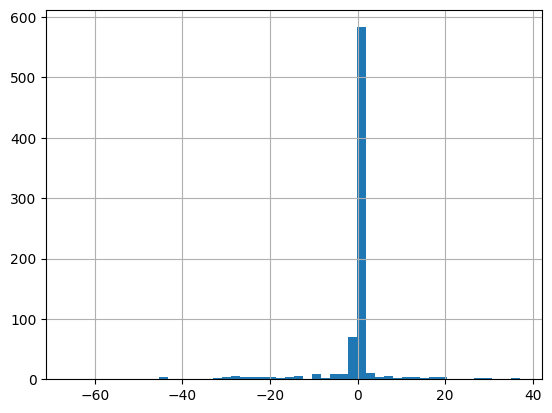

In [152]:
svy_voter.age_diff.hist(bins = 50)
plt.savefig("/home/quint/twitter_network/Soc science paper/Plots/csp_age_hist.png")

In [138]:
sum((svy_voter['age_diff'] <=1) & (svy_voter['age_diff'] >= -1))/svy_voter.shape[0]

0.8156565656565656

In [140]:
sum((svy_voter['age_diff'] <=2) & (svy_voter['age_diff'] >= -2))/svy_voter.shape[0]

0.8295454545454546

In [143]:
sum((svy_voter['age_diff'] >=5) | (svy_voter['age_diff'] <= -5))/svy_voter.shape[0]

0.12247474747474747

In [129]:
col_names = ['Female','Male']
df = compare(svy_voter, 'gender', 'gender_panel', col_names)
df

/tmp/ipykernel_57805/1572372645.py:21: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  ind = pd.unique([pair[0] for pair in pairs])
/tmp/ipykernel_57805/1572372645.py:22: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  col = pd.unique([pair[1] for pair in pairs])


,Female,Male
Female,527,15
Male,17,201


In [137]:
sum(np.diag(df))/(df.sum().sum())

0.9578947368421052

In [161]:
col_names = ["Republican", "Independent", "Democrat"]
ind_names = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]
df = compare(svy_voter.loc[~pd.isna(svy_voter.party7)], 'party7', 'party_id_panel', col_names, ind_names)
print(df)
print(df.div(df.sum(axis=0), axis=1).astype(float).round(2))
print(df.sum(axis=0))
print(df.sum(axis=0).sum())

    Republican Independent Democrat
1.0         65          13       30
2.0         45           9       22
3.0         25          10       13
4.0         31          21       52
5.0         22          13       49
6.0         17          25       84
7.0         31          27      186
     Republican  Independent  Democrat
1.0        0.28         0.11      0.07
2.0        0.19         0.08      0.05
3.0        0.11         0.08      0.03
4.0        0.13         0.18      0.12
5.0        0.09         0.11      0.11
6.0        0.07         0.21      0.19
7.0        0.13         0.23      0.43
Republican     236
Independent    118
Democrat       436
dtype: object
790


/tmp/ipykernel_57805/1572372645.py:21: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  ind = pd.unique([pair[0] for pair in pairs])
/tmp/ipykernel_57805/1572372645.py:22: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  col = pd.unique([pair[1] for pair in pairs])


In [162]:
col_names = ["Republican", "Independent", "Democrat"]
ind_names = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]
df = compare(svy_voter.loc[~pd.isna(svy_voter.party7)], 'party7', 'party_reg', col_names, ind_names)
print(df)
print(df.div(df.sum(axis=0), axis=1).astype(float).round(2))
print(df.sum(axis=0))
print(df.sum(axis=0).sum())

    Republican Independent Democrat
1.0         33          11       14
2.0         26          10        7
3.0         12           9        5
4.0          9          23       11
5.0          7          31       15
6.0         10          18       44
7.0         13          19       99
     Republican  Independent  Democrat
1.0        0.30         0.09      0.07
2.0        0.24         0.08      0.04
3.0        0.11         0.07      0.03
4.0        0.08         0.19      0.06
5.0        0.06         0.26      0.08
6.0        0.09         0.15      0.23
7.0        0.12         0.16      0.51
Republican     110
Independent    121
Democrat       195
dtype: object
426


/tmp/ipykernel_57805/1572372645.py:21: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  ind = pd.unique([pair[0] for pair in pairs])
/tmp/ipykernel_57805/1572372645.py:22: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  col = pd.unique([pair[1] for pair in pairs])


In [163]:
col_names = ["Republican", "Independent", "Democrat"]
df = compare(svy_voter, 'party3', 'party_id_panel', col_names)
print(df)
print(df.div(df.sum(axis=0), axis=1).astype(float).round(2))
print(df.sum(axis=0))
print(df.sum(axis=0).sum())

                  Republican Independent Democrat
Republican               112          22       52
Independent/Other         77          44      114
Democrat                  48          52      270
                   Republican  Independent  Democrat
Republican               0.47         0.19      0.12
Independent/Other        0.32         0.37      0.26
Democrat                 0.20         0.44      0.62
Republican     237
Independent    118
Democrat       436
dtype: object
791


/tmp/ipykernel_57805/1572372645.py:21: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  ind = pd.unique([pair[0] for pair in pairs])
/tmp/ipykernel_57805/1572372645.py:22: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  col = pd.unique([pair[1] for pair in pairs])


In [159]:
col_names = ["Republican", "Independent", "Democrat"]
df = compare(svy_voter, 'party3', 'party_reg', col_names)
print(df)
print(df.div(df.sum(axis=0), axis=1).astype(float).round(2))
print(df.sum(axis=0))
print(df.sum(axis=0).sum())

                  Republican Independent Democrat
Republican                61          21       21
Independent/Other         27          63       31
Democrat                  23          37      143
                   Republican  Independent  Democrat
Republican               0.55         0.17      0.11
Independent/Other        0.24         0.52      0.16
Democrat                 0.21         0.31      0.73
Republican     111
Independent    121
Democrat       195
dtype: object
427


/tmp/ipykernel_57805/1572372645.py:21: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  ind = pd.unique([pair[0] for pair in pairs])
/tmp/ipykernel_57805/1572372645.py:22: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  col = pd.unique([pair[1] for pair in pairs])


In [100]:
col_names = ["Republican", "Independent", "Democrat"]
ind_names = ["Trump", "Other/Not sure", "Biden"]
df = compare(svy_voter, 'vote', 'party_id_panel', col_names, ind_names)
print(df)
print(df.div(df.sum(axis=0), axis=1).astype(float).round(2))

               Republican Independent Democrat
Trump                 123          31       69
Other/Not sure         32          18       48
Biden                  83          69      318
               Republican Independent  Democrat
Trump            0.516807    0.262712  0.158621
Other/Not sure   0.134454    0.152542  0.110345
Biden            0.348739    0.584746  0.731034


/tmp/ipykernel_57805/1572372645.py:21: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  ind = pd.unique([pair[0] for pair in pairs])
/tmp/ipykernel_57805/1572372645.py:22: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  col = pd.unique([pair[1] for pair in pairs])


In [101]:
col_names = ["Republican", "Independent", "Democrat"]
ind_names = ["Trump", "Other/Not sure", "Biden"]
df = compare(svy_voter, 'vote', 'party_reg', col_names, ind_names)
print(df)
print(df.div(df.sum(axis=0), axis=1).astype(float).round(2))

               Republican Independent Democrat
Trump                  59          29       31
Other/Not sure         17          25       14
Biden                  36          67      150
               Republican Independent  Democrat
Trump            0.526786    0.239669  0.158974
Other/Not sure   0.151786    0.206612  0.071795
Biden            0.321429    0.553719  0.769231


/tmp/ipykernel_57805/1572372645.py:21: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  ind = pd.unique([pair[0] for pair in pairs])
/tmp/ipykernel_57805/1572372645.py:22: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  col = pd.unique([pair[1] for pair in pairs])
